<a href="https://colab.research.google.com/github/alonso0912/mineriarubrica/blob/main/Iris_Proyecto_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1) Instalación de dependencias

In [ ]:
!pip install -q scikit-learn pandas plotly joblib seaborn


## 2) Importar librerías

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import joblib
print('Librerías cargadas.')

Librerías cargadas.


## 3) Cargar el dataset


In [ ]:
# Ruta por defecto (ajusta si trabajas en Colab)
CSV_PATH = "Iris.csv"
if not os.path.exists(CSV_PATH):
    print("Archivo no encontrado en /mnt/data. Si estás en Colab, sube 'Iris.csv' o monta Google Drive y actualiza CSV_PATH.")
else:
    df = pd.read_csv(CSV_PATH)
    print(f"Dataset cargado desde: {CSV_PATH} — filas: {df.shape[0]}, columnas: {df.shape[1]}")
    display(df.head())

Dataset cargado desde: Iris.csv — filas: 150, columnas: 6


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


### 3.1 Inspección de columnas y estandarización de nombres

In [ ]:
# Estandarizar nombres de columnas si es necesario
def standardize_columns(df):
    col_map = {}
    for c in df.columns:
        lc = c.lower().strip()
        if "sepal" in lc and "length" in lc:
            col_map[c] = "sepal_length"
        if "sepal" in lc and "width" in lc:
            col_map[c] = "sepal_width"
        if "petal" in lc and "length" in lc:
            col_map[c] = "petal_length"
        if "petal" in lc and "width" in lc:
            col_map[c] = "petal_width"
        if "species" in lc or "class" in lc:
            col_map[c] = "species"
    df = df.rename(columns=col_map)
    return df

if 'df' in globals():
    df = standardize_columns(df)
    print("Columnas actuales:", df.columns.tolist())
else:
    print("DataFrame no cargado todavía.")

Columnas actuales: ['Id', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']


## 4) Información básica y valores faltantes

In [ ]:
if 'df' in globals():
    display(df.info())
    display(df.describe())
    print('\nValores faltantes por columna:')
    print(df.isnull().sum())
else:
    print("Carga el dataset primero.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            150 non-null    int64  
 1   sepal_length  150 non-null    float64
 2   sepal_width   150 non-null    float64
 3   petal_length  150 non-null    float64
 4   petal_width   150 non-null    float64
 5   species       150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


None

,Id,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000



Valores faltantes por columna:
Id              0
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64


## 5) Exploratory Data Analysis (EDA)

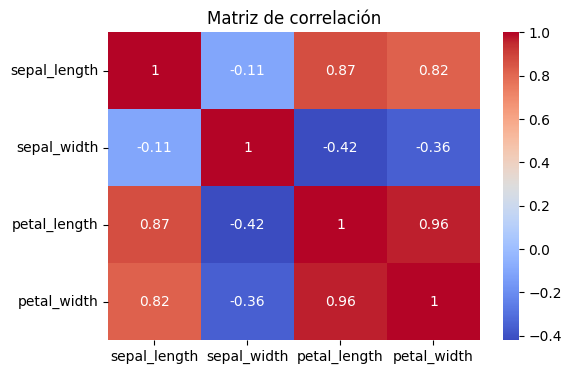

In [ ]:
if 'df' in globals():
    # Histogramas
    df_melt = df.melt(id_vars=['species']) if 'species' in df.columns else df.melt()
    fig = px.histogram(df_melt, x='value', color='species' if 'species' in df.columns else None, facet_col='variable', facet_col_wrap=2, title='Histogramas por variable')
    fig.show()
    # Scatter matrix
    fig2 = px.scatter_matrix(df, dimensions=['sepal_length','sepal_width','petal_length','petal_width'], color='species' if 'species' in df.columns else None, title='Scatter matrix')
    fig2.update_traces(diagonal_visible=False)
    fig2.show()
    # Heatmap correlation
    plt.figure(figsize=(6,4))
    sns.heatmap(df[['sepal_length','sepal_width','petal_length','petal_width']].corr(), annot=True, cmap='coolwarm')
    plt.title('Matriz de correlación')
    plt.show()
else:
    print('Carga el dataset primero.')

## 6) Preprocesamiento
Codificar etiquetas, train/test split y escalado.

In [ ]:
if 'df' in globals():
    X = df[['sepal_length','sepal_width','petal_length','petal_width']].values
    y = df['species'].values
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    print('Preprocesamiento completado. Tamaños — Train:', X_train.shape, 'Test:', X_test.shape)
else:
    print('Carga el dataset primero.')

Preprocesamiento completado. Tamaños — Train: (120, 4) Test: (30, 4)


## 7) Entrenamiento del modelo
Entrenamos RandomForest y probamos con GridSearchCV (opcional).

In [ ]:
if 'X_train_s' in globals():
    rf = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5]
    }
    grid = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_s, y_train)
    best = grid.best_estimator_
    print('Best params:', grid.best_params_)
    # Fit best on entire train set
    best.fit(X_train_s, y_train)
    # Save model, scaler, label encoder
    joblib.dump({'model': best, 'scaler': scaler, 'le': le}, 'model_iris_rf.joblib')
    print('Modelo entrenado y guardado: model_iris_rf.joblib')
else:
    print('Ejecuta las celdas de preprocesamiento antes.')

Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Modelo entrenado y guardado: model_iris_rf.joblib


## 8) Evaluación del modelo

In [ ]:
if 'best' in globals():
    y_pred = best.predict(X_test_s)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'F1-score: {f1:.4f}')
    print('\nClassification report:\n')
    print(classification_report(y_test, y_pred, target_names=le.inverse_transform([0,1,2])))
    cm = confusion_matrix(y_test, y_pred)
    fig = px.imshow(cm, labels=dict(x='Predicho', y='Real'), x=le.inverse_transform([0,1,2]), y=le.inverse_transform([0,1,2]), text_auto=True)
    fig.update_layout(title='Matriz de confusión')
    fig.show()
else:
    print('Entrena el modelo primero.')

Accuracy: 0.9000
Precision: 0.9024
Recall: 0.9000
F1-score: 0.8997

Classification report:

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.82      0.90      0.86        10
 Iris-virginica       0.89      0.80      0.84        10

       accuracy                           0.90        30
      macro avg       0.90      0.90      0.90        30
   weighted avg       0.90      0.90      0.90        30



## 9) Predicción de nuevas muestras

In [ ]:
# Ejemplo: predecir una nueva muestra
if 'best' in globals():
    sample = np.array([[5.1, 3.5, 1.4, 0.2]])  # cambiar si quieres
    sample_s = scaler.transform(sample)
    pred = best.predict(sample_s)[0]
    probs = best.predict_proba(sample_s)[0]
    print('Predicción:', le.inverse_transform([pred])[0])
    print('Probabilidades por clase:')
    for name, p in zip(le.inverse_transform([0,1,2]), probs):
        print(f'{name}: {p:.3f}')
else:
    print('Entrena el modelo primero.')

Predicción: Iris-setosa
Probabilidades por clase:
Iris-setosa: 1.000
Iris-versicolor: 0.000
Iris-virginica: 0.000


## 10) Generar archivos del proyecto
Crea `Proyecto.py`, `requirements.txt` y `README.md` listos para subir a GitHub.

In [ ]:
project_py = r'''
# Proyecto.py
# App Streamlit para "Iris Species Classification"
# Guarda este archivo como Proyecto.py y ejecuta:
# streamlit run Proyecto.py

import streamlit as st
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib, os
import plotly.express as px

MODEL_PATH = "model_iris_rf.joblib"
CSV_PATHS = ["iris.csv", "Iris.csv", "/mnt/data/Iris.csv"]
st.set_page_config(page_title="Iris Species Classification", layout="wide")

@st.cache_data
def load_iris_df():
    for p in CSV_PATHS:
        if os.path.exists(p):
            return pd.read_csv(p)
    from sklearn import datasets
    iris = datasets.load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
    df["species"] = pd.Categorical.from_codes(iris.target, iris.target_names)
    return df

df = load_iris_df()

st.sidebar.title("Proyecto: Iris Species Classification")
sep_len = st.sidebar.number_input("Sepal length (cm)", value=5.1, format="%.2f")
sep_wid = st.sidebar.number_input("Sepal width (cm)", value=3.5, format="%.2f")
pet_len = st.sidebar.number_input("Petal length (cm)", value=1.4, format="%.2f")
pet_wid = st.sidebar.number_input("Petal width (cm)", value=0.2, format="%.2f")
predict_btn = st.sidebar.button("Predecir especie")

st.title("Iris Species Classification — Proyecto")
with st.expander("Vista rápida del dataset"):
    st.write(df.head())

fig_hist = px.histogram(df.melt(id_vars="species"), x="value", color="species", facet_col="variable", facet_col_wrap=2)
st.plotly_chart(fig_hist, use_container_width=True)

X = df[["sepal_length","sepal_width","petal_length","petal_width"]].values
y = df["species"].values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

if os.path.exists(MODEL_PATH):
    saved = joblib.load(MODEL_PATH)
    rf = saved["model"]
    scaler = saved["scaler"]
    le = saved["le"]
else:
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_s, y_train)
    joblib.dump({"model": rf, "scaler": scaler, "le": le}, MODEL_PATH)

y_pred = rf.predict(X_test_s)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

st.subheader("Métricas")
st.write(f"Accuracy: {acc:.4f}")
st.write(f"Precision: {prec:.4f}")
st.write(f"Recall: {rec:.4f}")
st.write(f"F1-score: {f1:.4f}")

if predict_btn:
    new_sample = np.array([[sep_len, sep_wid, pet_len, pet_wid]])
    new_sample_s = scaler.transform(new_sample)
    pred_code = rf.predict(new_sample_s)[0]
    pred_species = le.inverse_transform([pred_code])[0]
    st.success(f"Especie predicha: **{pred_species}**")
'''

with open('Proyecto.py','w',encoding='utf-8') as f:
    f.write(project_py)

with open('requirements.txt','w',encoding='utf-8') as f:
    f.write('streamlit>=1.18\nscikit-learn>=1.2\npandas>=1.5\nnumpy>=1.23\nplotly>=5.6\njoblib>=1.2\n')

with open('README.md','w',encoding='utf-8') as f:
    f.write('''# Iris Species Classification\n\nNotebook generado que entrena un RandomForest con Iris.csv y crea archivos del proyecto.\n''')

print('Archivos Proyecto.py, requirements.txt y README.md generados en el directorio de trabajo.')

Archivos Proyecto.py, requirements.txt y README.md generados en el directorio de trabajo.


## 11) Instrucciones para ejecutar en Google Colab
Si vas a usar Google Colab:
- Sube `Iris.csv` con el botón de archivos o monta Google Drive.
- Ajusta `CSV_PATH` en la celda de carga o copia `Iris.csv` al entorno.

Para ejecutar Streamlit desde Colab (opcional) se puede usar `ngrok` o `localtunnel` — incluyo referencia en el README si lo necesitas.